# Mouse cell line and tumor allografts

In [1]:
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(1, "/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/")
import mazebox as mb

# Preprocessing

## Read in Files

In [2]:
indir = "../data/untreated-cline-allografts/"
outdir = './out/processed-data/untreated-cline-allografts'
samples = [f for f in os.listdir(indir) if f.endswith('.loom')]
print(samples)
[a1,a2,a3,a4] = [mb.pp.read_loom(sample.split('.')[0], indir) for sample in samples] #split to remove .loom from file name


['SC152_KP3_possorted_genome_bam_J96W9.loom', 'SC152_KP1_possorted_genome_bam_TU6GD.loom', 'SC152_KP11_possorted_genome_bam_BKL4A.loom', 'SC152_HES_possorted_genome_bam_IHJKC.loom']


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Filter and concatenate

In [3]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']


In [4]:
batch_categories = ['KP3','KP1','KP11','HES']
batch_key = 'tumor'

adata = a1.concatenate([a2,a3, a4], batch_key=batch_key, batch_categories=batch_categories)


In [5]:
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

Filtered out 8898 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [6]:
adata

AnnData object with n_obs × n_vars = 22207 × 23387
    obs: 'tumor', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

### Filter using cell IDs from Fred Xi

## Cell Cycle Regression

I am choosing not to rescale the data: https://github.com/theislab/scvelo/issues/156

>"Scaling has the effect that all genes are weighted equally for downstream analysis. There is currently no consensus on whether or not to perform normalization over genes. While the popular Seurat tutorials (Butler et al, 2018) generally apply gene scaling, the authors of the Slingshot method opt against scaling over genes in their tutorial (Street et al, 2018)".'

It tends to affect the distance calculations, etc. and I do not see a reason to assume all gene are equally important in downstream analysis.

In [7]:
adata.var.index = adata.var.index.str.upper()

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'phase' as categorical


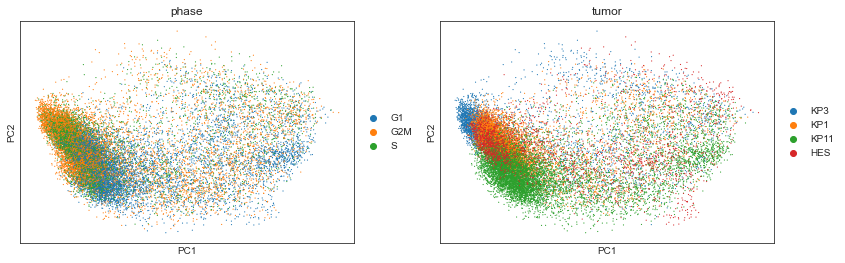

In [8]:
# sc.pp.scale(adata) #choosing not to rescale the data
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','tumor'])

In [9]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

# Dimensionality Reduction and RNA Velocity

In [20]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)


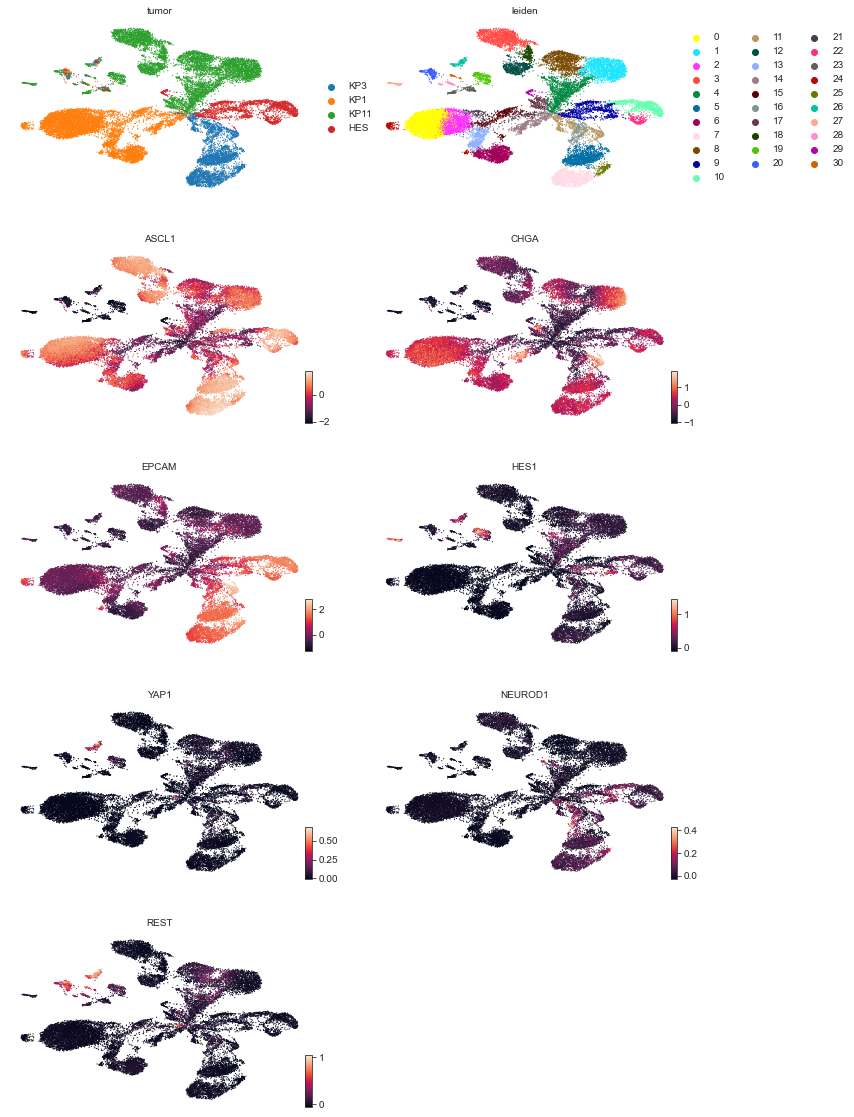

In [27]:
scv.pl.scatter(adata, color = ['tumor','leiden','ASCL1','CHGA','EPCAM','HES1','YAP1','NEUROD1','REST'], ncols = 2,
              smooth = True, basis='umap', legend_loc='on right')


In [28]:
adata.write_h5ad(outdir+"/adata_01.h5ad")